# FMA: A Dataset For Music Analysis

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Usage

1. Go through the [paper] to understand what the data is about.
1. Download some datasets from <https://github.com/mdeff/fma>.
1. Uncompress the archives, e.g. with `unzip fma_small.zip`.
1. Load and play with the data in this notebook.

[paper]: https://arxiv.org/abs/1612.01840

In [1]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils

plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')
print(AUDIO_DIR)

C:\Users\bisar\Desktop\IIT\Courses\Spring 2020\Deep Learning\FInal Project\Main Ref Docs\fma\test_audio_files


In [3]:

# Load metadata and features.
tracks = utils.load('fma_metadata/tracks.csv')
genres = utils.load('fma_metadata/genres.csv')
features = utils.load('fma_metadata/features.csv')
echonest = utils.load('fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

## 1 Metadata

The metadata table, a CSV file in the `fma_metadata.zip` archive, is composed of many colums:
1. The index is the ID of the song, taken from the website, used as the name of the audio file.
2. Per-track, per-album and per-artist metadata from the Free Music Archive website.
3. Two columns to indicate the subset (small, medium, large) and the split (training, validation, test).

In [ ]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())

## 2 Genres

The genre hierarchy is stored in `genres.csv` and distributed in `fma_metadata.zip`.

In [ ]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

In [ ]:
genres.sort_values('#tracks').head()

In [ ]:
genres['top_level'].unique()

## 3 Features

1. Features extracted from the audio for all tracks.
2. For some tracks, data colected from the [Echonest](http://the.echonest.com/) API.

In [ ]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

### 3.1 Echonest features

In [ ]:
print('{1} features for {0} tracks'.format(*echonest.shape))
ipd.display(echonest['echonest', 'metadata'].head())
ipd.display(echonest['echonest', 'audio_features'].head())
ipd.display(echonest['echonest', 'social_features'].head())
ipd.display(echonest['echonest', 'ranks'].head())

In [ ]:
ipd.display(echonest['echonest', 'temporal_features'].head())
x = echonest.loc[2, ('echonest', 'temporal_features')]
plt.plot(x);

### 3.2 Features like MFCCs are discriminant

In [ ]:
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Instrumental'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

X = features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

## 4 Audio

You can load the waveform and listen to audio in the notebook itself.

In [ ]:
filename = utils.get_audio_path(AUDIO_DIR, 2)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

And use [librosa](https://github.com/librosa/librosa) to compute spectrograms and audio features.

In [ ]:
librosa.display.waveplot(x, sr, alpha=0.5);
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1));

In [ ]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');

In [ ]:
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis='time');

## 5 Genre classification

### 5.1 From features

In [39]:
import numpy as np
from keras import models
from keras import layers
import copy
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from keras import optimizers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder



In [86]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
x_train = features.loc[small & train, 'mfcc']
x_test = features.loc[small & test, 'mfcc']

y_val = tracks.loc[small & val, ('track', 'genre_top')]
x_val = features.loc[small & val, 'mfcc']


print('{} training examples, {} testing examples'.format(y_train.shape, y_test.size))
print('{} val examples'.format(y_val.size))

print('{} features, {} classes'.format(x_train.shape, np.unique(y_train).size))

(6400,) training examples, 800 testing examples
800 val examples
(6400, 140) features, 8 classes


In [78]:
def one_hot_enc(y_data):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y_data)
    print(integer_encoded.size)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#     print(onehot_encoded.shape)
    return onehot_encoded

In [87]:
print('{} training examples, {} testing examples'.format(y_train.shape, y_test.size))
print('{} val examples'.format(y_val.size))

print('{} features, {} classes'.format(x_train.shape, np.unique(y_train).size))

# Be sure training samples are shuffled.
x_train, y_train = skl.utils.shuffle(x_train, y_train, random_state=42)
x_val, y_val = skl.utils.shuffle(x_val, y_val, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(x_train)
scaler.transform(x_test)
scaler.transform(x_val)

y_train = one_hot_enc(y_train)
y_val = one_hot_enc(y_val)
y_test = one_hot_enc(y_test)

x_train = x_train.as_matrix()
x_val = x_val.as_matrix()
x_test = x_test.as_matrix()

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))



# # Support vector classification.
# clf = skl.svm.SVC()
# clf.fit(X_train, y_train)
# score = clf.score(X_test, y_test)
# print('Accuracy: {:.2%}'.format(score))

(6400,) training examples, 800 testing examples
800 val examples
(6400, 140) features, 8 classes
6400
800
800
51200 training examples, 6400 testing examples


c:\users\bisar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\bisar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\bisar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [55]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10374180331617940291
]


In [ ]:
pip freeze

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

In [97]:
def generate_model(input_shape):
    model = models.Sequential()
    # Hidden layers cannot be too small because if it is, then there will be information loss
    model.add(layers.Dense(512, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))

    model.add(layers.Dense(8, activation='softmax'))

    # Compile the model
    # Use sparse categorical cross entropy for loss if NOT using one hot encoding. Both give same results
    model.compile(
        optimizer=optimizers.Adam(lr=0.001),
        loss='categorical_crossentropy', metrics=['acc'])
    return model

In [89]:
def plot_epocs_graph(history_dict, bin_acc=True):
    loss_vals = history_dict['loss']
    val_loss_vals = history_dict['val_loss']
    epochs = range(1, len(history_dict['binary_accuracy'] if bin_acc else history_dict['acc']) + 1)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_vals, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss_vals, 'b', label='Validation Loss')
    plt.title("Training and validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    acc_vals = history_dict['binary_accuracy'] if bin_acc else history_dict['acc']
    val_acc_vals = history_dict['val_binary_accuracy'] if bin_acc else history_dict['val_acc']
    plt.plot(epochs, acc_vals, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc_vals, 'b', label='Validation accuracy')
    plt.title("Training and validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # plt.savefig("../doc/graphs/val_loss_acc_epochs_task1.png")
    plt.show()
    return

Train on 6400 samples, validate on 800 samples
Epoch 1/12
6400/6400 [==============================] - 1s - loss: 1.8456 - acc: 0.2964 - val_loss: 1.5677 - val_acc: 0.4337
Epoch 2/12
6400/6400 [==============================] - 0s - loss: 1.5289 - acc: 0.4477 - val_loss: 1.4358 - val_acc: 0.4713
Epoch 3/12
6400/6400 [==============================] - 0s - loss: 1.4249 - acc: 0.4873 - val_loss: 1.3650 - val_acc: 0.5125
Epoch 4/12
6400/6400 [==============================] - 0s - loss: 1.3279 - acc: 0.5272 - val_loss: 1.3351 - val_acc: 0.5325
Epoch 5/12
6400/6400 [==============================] - 0s - loss: 1.2636 - acc: 0.5472 - val_loss: 1.3263 - val_acc: 0.5337
Epoch 6/12
6400/6400 [==============================] - 0s - loss: 1.2280 - acc: 0.5641 - val_loss: 1.3528 - val_acc: 0.5275
Epoch 7/12
6400/6400 [==============================] - 0s - loss: 1.1840 - acc: 0.5855 - val_loss: 1.3844 - val_acc: 0.5212
Epoch 8/12
6400/6400 [==============================] - 0s - loss: 1.1448 - ac

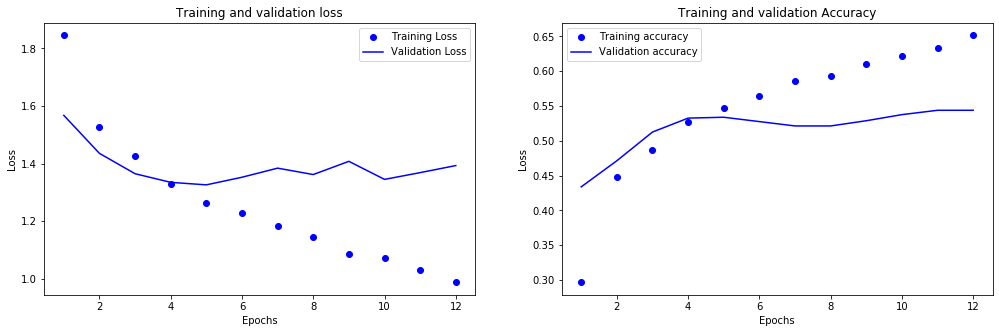

 32/800 [>.............................] - ETA: 0s
 Test Accuracy 43.5


In [98]:

def build_train_validate(x_train, y_train, input_shape, x_val, y_val):
    # Build the network
    model = generate_model(input_shape)

#     # Training and validation
    history = model.fit(x_train, y_train, nb_epoch=12, batch_size=512, validation_data=(x_val, y_val))
    history_dict = history.history
    print(history_dict.keys())
    print(f'avg accuracy {np.mean(history_dict["acc"])}')
    print(f'val avg accuracy {np.mean(history_dict["val_acc"])}')
    plot_epocs_graph(history_dict, False)
    results = model.evaluate(x_test, y_test)
    print(f'\n Test Accuracy {results[1]*100}')
    return model

build_train_validate(x_train, y_train, x_train.shape[1:], x_val, y_val)

### 5.2 From audio